# Fairness in ML book

Based on [example notebook](https://fairmlbook.org/code/adult.html) used for example from the [Fairness in ML](https://fairmlbook.org/classification.html) book, chapter 2.
Also helpful is the github notebook from [lecture 8](https://github.com/afraenkel/fairness-book/blob/main/book/content/08-compas-2.ipynb). 

Uses [UCI](https://archive.ics.uci.edu/ml/datasets/adult) census income data.
Attempting to predict whether income exceeds $50K a year, based on features.

[Link](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/) to data.

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(6,6)})

import pandas as pd
import pylab
import numpy as np
import sklearn
from sklearn import linear_model
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
from statsmodels.stats import proportion

## Preprocess UCI adult data



In [13]:
# Source: https://www.valentinmihov.com/2015/04/17/adult-income-data-set/

features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 

# Change these to local file if available
train_url = './data/adult.data'
test_url = './data/adult.test'

# This will download 3.8M
original_train = pd.read_csv(train_url, names=features, sep=r'\s*,\s*', 
                             engine='python', na_values="?")
# This will download 1.9M
original_test = pd.read_csv(test_url, names=features, sep=r'\s*,\s*', 
                            engine='python', na_values="?", skiprows=1)

num_train = len(original_train)
original = pd.concat([original_train, original_test])
roc_original = original
labels = original['Target']
labels = labels.replace('<=50K', 0).replace('>50K', 1)
labels = labels.replace('<=50K.', 0).replace('>50K.', 1)

# Redundant column
del original["Education"]

# Remove target variable
del original["Target"]

def data_transform(df):
    """Normalize features."""
    binary_data = pd.get_dummies(df)
    feature_cols = binary_data[binary_data.columns[:-2]]
    scaler = preprocessing.StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(feature_cols), columns=feature_cols.columns)
    return data

data = data_transform(original)
train_data = data[:num_train]
train_labels = labels[:num_train]
test_data = data[num_train:]
test_labels = labels[num_train:]

## Logistic regression model

The target, dependent variable is whether income exceeds $50K a year.

In [3]:
cls = linear_model.LogisticRegression()
cls.fit(train_data, train_labels)

LogisticRegression()

In [14]:
# Note that sklearn predict is using 0.5 threshold
predictions = cls.predict(test_data)
# binary; will return [prob. in negative class, prob. in positive class]
scores = cls.predict_proba(test_data)[:, 1]

d = {'target' : test_labels.values,
     'score' : scores,
     'prediction' : predictions,
     'race' : original_test['Race'],
     'gender' : original_test['Sex']}

marginals = pd.DataFrame(data=d, columns=['target', 'score', 'prediction', 'race', 'gender'])
marginals.head()

,target,score,prediction,race,gender
0,0,0.002752,0,Black,Male
1,0,0.117700,0,White,Male
2,1,0.456652,0,White,Male
3,1,0.754372,1,Black,Male
4,0,0.001220,0,White,Female


In [15]:
freq = marginals.groupby(
    ['race', pd.cut(marginals['score'], np.linspace(0, 1, 11))]
)['target'].agg(['sum', 'count'])
freq['rate'] = freq['sum'] / freq['count']
# Get the max of the index
freq.index = freq.index.set_levels(freq.index.levels[1].rename_categories(lambda x: x.right), level=1)
# replace with float value instead of categorical
freq.index = freq.index.set_levels(freq.index.levels[1].categories, level=1)

# Find confidence bands
ci_low, ci_high = proportion.proportion_confint(freq['sum'], freq['count'], alpha=.05)

/Users/tarasullivan/opt/miniconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:89: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs


Text(0, 0.5, 'Rate of positive outcomes')

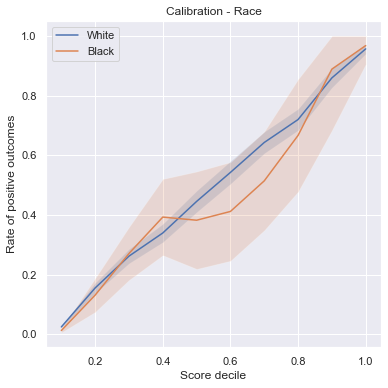

In [17]:
race = ['White', 'Black']

fig, ax = plt.subplots()

for race in ['White', 'Black']:
    freq.loc[race].plot(y='rate', label=race, ax=ax)
    pylab.fill_between(ci_low.index.levels[1].values, ci_low.loc[race], ci_high.loc[race], alpha=.2,)

ax.set_title('Calibration - Race')
ax.set_xlabel('Score decile')
ax.set_ylabel('Rate of positive outcomes')

In [18]:
freq = marginals.groupby(
    ['gender', pd.cut(marginals['score'], np.linspace(0, 1, 11))]
)['target'].agg(['sum', 'count'])
freq['rate'] = freq['sum'] / freq['count']
# Get the max of the index
freq.index = freq.index.set_levels(freq.index.levels[1].rename_categories(lambda x: x.right), level=1)
# replace with float value instead of categorical
freq.index = freq.index.set_levels(freq.index.levels[1].categories, level=1)

# Find confidence bands
ci_low, ci_high = proportion.proportion_confint(freq['sum'], freq['count'], alpha=.05)

Text(0, 0.5, 'Rate of positive outcomes')

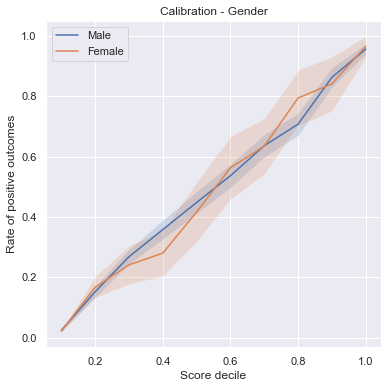

In [19]:
fig, ax = plt.subplots()

for gender in ['Male', 'Female']:
    freq.loc[gender].plot(y='rate', label=gender, ax=ax)
    pylab.fill_between(ci_low.index.levels[1].values, ci_low.loc[gender], ci_high.loc[gender], alpha=.2,)

ax.set_title('Calibration - Gender')
ax.set_xlabel('Score decile')
ax.set_ylabel('Rate of positive outcomes')

Note that the model is well-calibrated for gender, without really doing anything!
* Sufficiency often (approximately) comes for free 
* Means that it might not make substantial changes needed

## Calculate ROC

In [20]:
def calc_roc(x, **kwargs):
    fpr, tpr, thresh = metrics.roc_curve(
        x['target'], x['score'], **kwargs)
    return pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresh': thresh})

male = calc_roc(marginals[marginals['gender'] == 'Male'], drop_intermediate=True)
female = calc_roc(marginals[marginals['gender'] == 'Female'], drop_intermediate=True)

black = calc_roc(marginals[marginals['race'] == 'Black'])
white = calc_roc(marginals[marginals['race'] == 'White'])

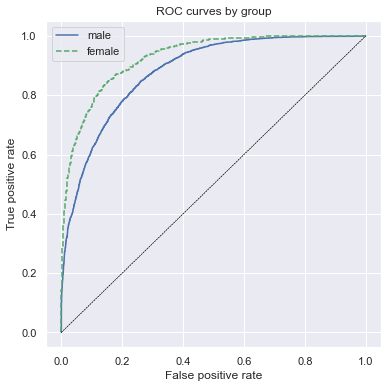

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(male['fpr'], male['tpr'], '-b', label='male')
ax.plot(female['fpr'], female['tpr'], '--g', label='female')
ax.set_title('ROC curves by group')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')

ax.plot([(0,0), (1,1)], '--k', linewidth=0.5)

ax.legend()

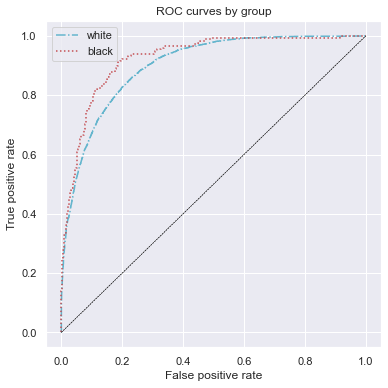

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(white['fpr'], white['tpr'], '-.c', label='white')
ax.plot(black['fpr'], black['tpr'], ':r', label='black')
ax.set_title('ROC curves by group')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')

ax.plot([(0,0), (1,1)], '--k', lw=0.5)

ax.legend()